# Análise de Churn de Clientes – Telecom X

**Autor:** Mauro Cahu  
**Data:** 2025-06-03  
**Projeto:** Challenge Telecom X  

**Resumo:**  
Este notebook consolida todo o processo de ETL, limpeza, análise exploratória e insights para reduzir o churn (evasão) de clientes na Telecom X.

## 1. Introdução

A Telecom X tem observado um crescente índice de evasão de clientes (churn), impactando diretamente sua receita e capacidade de manter um fluxo recorrente estável.  
O objetivo desta análise é:

1. **Entender** o perfil dos clientes que cancelam o serviço em comparação com os que permanecem.
2. **Identificar** padrões em dados demográficos (gênero, idade, dependentes), comportamentais (tipo de plano, serviços contratados) e financeiros (valor gasto, tempo de contrato).
3. **Gerar insights** e **recomendações** que possam ser utilizados pela equipe de marketing e retenção para reduzir o churn.


In [12]:
# 2. Importar bibliotecas necessárias
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)

# Definir caminhos (ajuste de acordo com a organização do seu projeto)
BASE_DIR    = os.getcwd()  # Em Jupyter, assume a pasta onde o notebook está salvo
CLEAN_CSV   = os.path.join(BASE_DIR, "data", "clean", "telecom_churn_cleaned.csv")
FEATURES_CSV = os.path.join(BASE_DIR, "data", "clean", "telecom_churn_features.csv")
TRANSFORMED_CSV = os.path.join(BASE_DIR, "data", "clean", "telecom_churn_transformed.csv")
REPORTS_DIR = os.path.join(BASE_DIR, "reports")

# Carregar os dados (usar o CSV final transformado para todas as análises)
df = pd.read_csv(TRANSFORMED_CSV)
print("Dimensões do DataFrame transformado:", df.shape)
df.head(3)


Dimensões do DataFrame transformado: (7267, 22)


,ID_Cliente,Evasao,Genero,Idoso,Tem_Conjuge,Tem_Dependentes,Meses_Contratado,Tem_Telefone,Linhas_Adicionais,Tipo_Internet,...,Prot_Dispositivos,Suporte_Tecnico,Streaming_TV,Streaming_Filmes,Tipo_Contrato,Fatura_Digital,Metodo_Pagamento,Cobranca_Mensal,Cobranca_Total,Cobranca_Diaria
0,0002-ORFBO,0.0,1,0,1,1,9,1,0.0,DSL,...,0,1,1,0,Anual,1,Cheque Enviado,65.6,593.3,2.19
1,0003-MKNFE,0.0,0,0,0,0,9,1,1.0,DSL,...,0,0,0,1,Mensal,0,Cheque Enviado,59.9,542.4,2.00
2,0004-TLHLJ,1.0,0,0,0,0,4,1,0.0,Fibra Optica,...,1,0,0,0,Mensal,1,Cheque Eletronico,73.9,280.85,2.46


## 2. Limpeza e Tratamento de Dados

Nesta seção, descrevemos — resumidamente — todas as etapas de ETL que executamos antes de chegar ao arquivo `telecom_churn_transformed.csv`.  

1. **Importação do JSON bruto**  
   - Utilizamos a API (JSON) disponibilizada pela Telecom X.  
   - Leitura com `pd.json_normalize()`.  

2. **Criação do DataFrame completo**  
   - Extraímos colunas originais como `customerID`, `Churn`, `customer.gender`, `customer.SeniorCitizen`, etc.  

3. **Subsetting das colunas relevantes**  
   - Selecionamos apenas variáveis afetas à análise de churn:  
     - Variáveis demográficas: `customer.gender` → “Genero”, `customer.SeniorCitizen` → “Idoso”, `customer.Partner` → “Tem_Conjuge”, `customer.Dependents` → “Tem_Dependentes”.  
     - Tempo de contrato: `customer.tenure` → “Meses_Contratado”.  
     - Serviços de telefone/internet: `phone.PhoneService` → “Tem_Telefone”, `phone.MultipleLines` → “Linhas_Adicionais`, etc.  
     - Plano financeiro: `account.Contract` → “Tipo_Contrato”, `account.Charges.Monthly` → “Cobranca_Mensal”, `account.Charges.Total` → “Cobranca_Total”.  
     - Coluna `Churn` (alvo), convertida posteriormente em “Evasao” (0/1).  

4. **Tratamento de valores ausentes e duplicados**  
   - `total_charges` (Cobranca_Total) preenchido com mediana em casos vazios.  
   - Remoção de duplicados com base em `customerID`.  

5. **Padronização de strings**  
   - Aplicamos `.str.strip().str.lower()` em todas as colunas categóricas, garantindo que “Yes”, “ yes “ e “YES” fossem uniformes como “yes”/“no”.  

6. **Criação de subset final**  
   - Geração do CSV `telecom_churn_cleaned.csv` contendo colunas limpas e padronizadas.  

7. **Feature Engineering (Cálculo de coluna “Contas_Diarias”)**  
   - `Contas_Diarias = Cobranca_Mensal / 30`, arredondado em 2 casas decimais. Salvamos como `telecom_churn_features.csv`.  

8. **Transformação e tradução para português**  
   - Renomeamos todas as colunas para termos em português (“customerID” → “ID_Cliente”, “Churn” → “Evasao”, “customer.gender” → “Genero”, etc.).  
   - Convertimos todas as colunas binárias (“yes”/“no” ou “no internet service”) para 1/0.  
   - Traduzimos categorias textuais como “fiber optic” → “Fibra Óptica”, “month-to-month” → “Mensal”, “electronic check” → “Cheque Eletrônico”, etc.  
   - Salvamos como `telecom_churn_transformed.csv`.  

A partir daqui, o DataFrame `df` carregado já possui colunas em português, valores numéricos e está pronto para análise exploratória.


## 3. Análise Exploratória de Dados (EDA)

Nesta seção, examinamos visualmente como as variáveis se comportam em relação à evasão de clientes.  
Incluímos gráficos de distribuição, boxplots, countplots e heatmap de correlação.


C:\Users\mauro\AppData\Local\Temp\ipykernel_28912\298349273.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


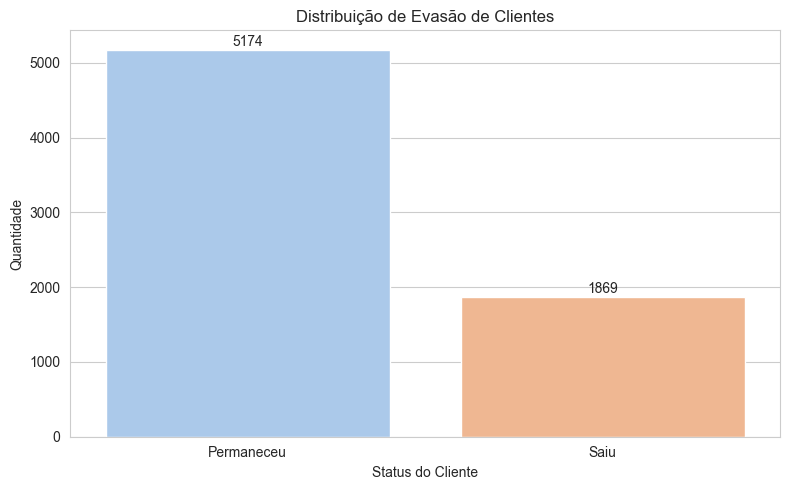

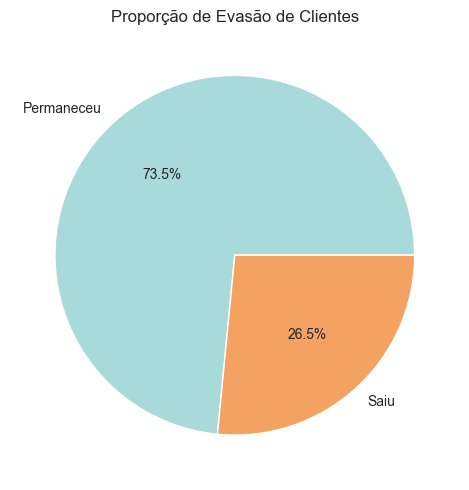

Quantidade de clientes (0=Permaneceu, 1=Saiu):
{0.0: 5174, 1.0: 1869}

Porcentagem de clientes:
{0.0: 73.46, 1.0: 26.54}


In [13]:
# 3.1. Distribuição geral de Evasão (churn)
churn_counts = df["Evasao"].value_counts().sort_index()
churn_percent = churn_counts / churn_counts.sum() * 100

# Gráfico de Barras
plt.figure()
sns.barplot(
    x=churn_counts.index.map({0: "Permaneceu", 1: "Saiu"}),
    y=churn_counts.values,
    palette="pastel"
)
plt.title("Distribuição de Evasão de Clientes")
plt.xlabel("Status do Cliente")
plt.ylabel("Quantidade")
for i, count in enumerate(churn_counts.values):
    plt.text(i, count + churn_counts.max()*0.01, f"{count}", ha="center")
plt.tight_layout()
plt.show()

# Gráfico de Pizza
plt.figure()
plt.pie(
    churn_counts.values,
    labels=churn_counts.index.map({0: "Permaneceu", 1: "Saiu"}),
    autopct="%1.1f%%",
    colors=["#a8dadc", "#f4a261"]
)
plt.title("Proporção de Evasão de Clientes")
plt.tight_layout()
plt.show()

# Imprimir contagens e porcentagens
print("Quantidade de clientes (0=Permaneceu, 1=Saiu):")
print(churn_counts.to_dict())
print("\nPorcentagem de clientes:")
print(churn_percent.round(2).to_dict())


### 3.2. Churn por Variáveis Categóricas

Vamos verificar a taxa de churn em função de cada coluna categórica de interesse:
- Gênero (`Genero`)
- Idoso (`Idoso`)
- Tem Cônjuge (`Tem_Conjuge`)
- Tem Dependentes (`Tem_Dependentes`)
- Tipo de Contrato (`Tipo_Contrato`)
- Método de Pagamento (`Metodo_Pagamento`)
- Tipo de Internet (`Tipo_Internet`)
- Fatura Digital (`Fatura_Digital`)


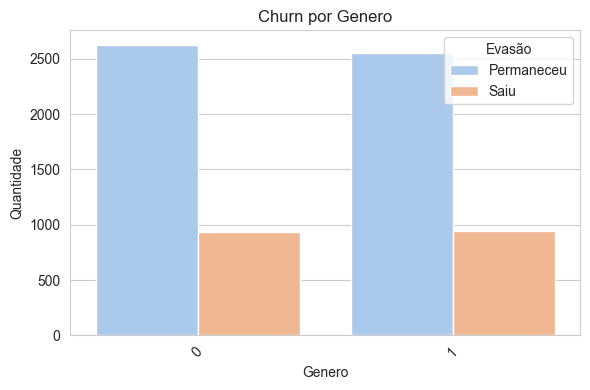


=== Contagem de Genero × Evasao ===


,Permaneceu,Saiu
Genero,,
0,2625,930
1,2549,939



=== Porcentagem de Genero × Evasao (%) ===


,Permaneceu,Saiu
Genero,,
0,73.84,26.16
1,73.08,26.92



--------------------------------------------------



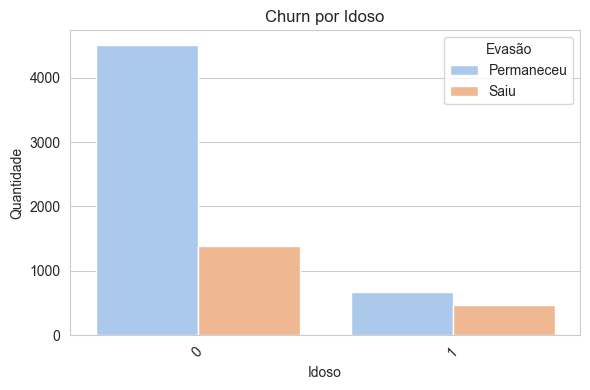


=== Contagem de Idoso × Evasao ===


,Permaneceu,Saiu
Idoso,,
0,4508,1393
1,666,476



=== Porcentagem de Idoso × Evasao (%) ===


,Permaneceu,Saiu
Idoso,,
0,76.39,23.61
1,58.32,41.68



--------------------------------------------------



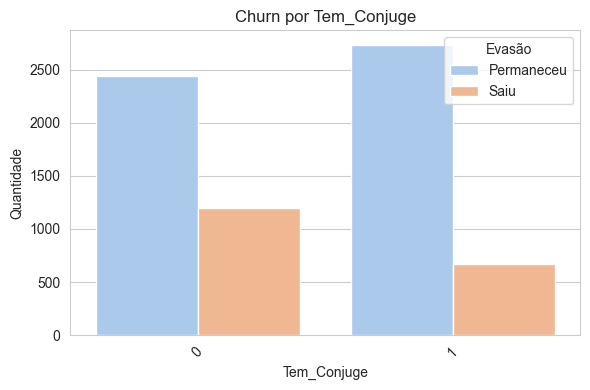


=== Contagem de Tem_Conjuge × Evasao ===


,Permaneceu,Saiu
Tem_Conjuge,,
0,2441,1200
1,2733,669



=== Porcentagem de Tem_Conjuge × Evasao (%) ===


,Permaneceu,Saiu
Tem_Conjuge,,
0,67.04,32.96
1,80.34,19.66



--------------------------------------------------



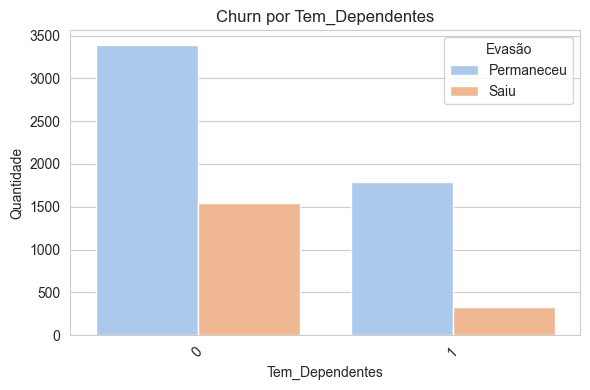


=== Contagem de Tem_Dependentes × Evasao ===


,Permaneceu,Saiu
Tem_Dependentes,,
0,3390,1543
1,1784,326



=== Porcentagem de Tem_Dependentes × Evasao (%) ===


,Permaneceu,Saiu
Tem_Dependentes,,
0,68.72,31.28
1,84.55,15.45



--------------------------------------------------



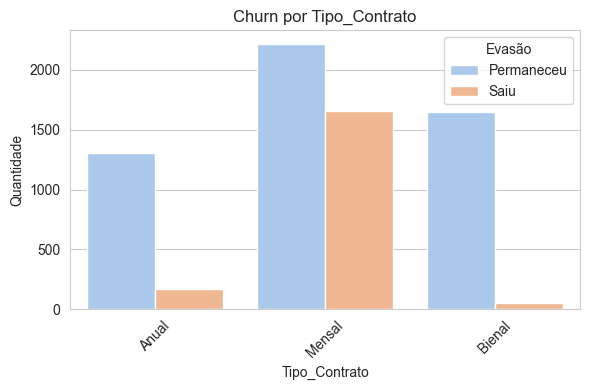


=== Contagem de Tipo_Contrato × Evasao ===


,Permaneceu,Saiu
Tipo_Contrato,,
Anual,1307,166
Bienal,1647,48
Mensal,2220,1655



=== Porcentagem de Tipo_Contrato × Evasao (%) ===


,Permaneceu,Saiu
Tipo_Contrato,,
Anual,88.73,11.27
Bienal,97.17,2.83
Mensal,57.29,42.71



--------------------------------------------------



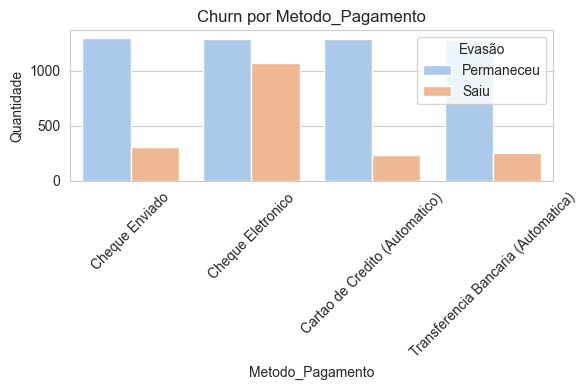


=== Contagem de Metodo_Pagamento × Evasao ===


,Permaneceu,Saiu
Metodo_Pagamento,,
Cartao de Credito (Automatico),1290,232
Cheque Eletronico,1294,1071
Cheque Enviado,1304,308
Transferencia Bancaria (Automatica),1286,258



=== Porcentagem de Metodo_Pagamento × Evasao (%) ===


,Permaneceu,Saiu
Metodo_Pagamento,,
Cartao de Credito (Automatico),84.76,15.24
Cheque Eletronico,54.71,45.29
Cheque Enviado,80.89,19.11
Transferencia Bancaria (Automatica),83.29,16.71



--------------------------------------------------



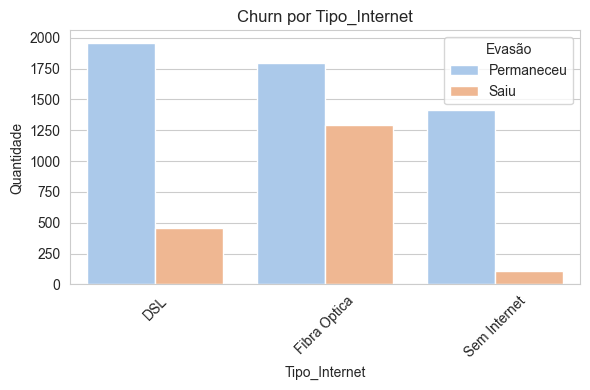


=== Contagem de Tipo_Internet × Evasao ===


,Permaneceu,Saiu
Tipo_Internet,,
DSL,1962,459
Fibra Optica,1799,1297
Sem Internet,1413,113



=== Porcentagem de Tipo_Internet × Evasao (%) ===


,Permaneceu,Saiu
Tipo_Internet,,
DSL,81.04,18.96
Fibra Optica,58.11,41.89
Sem Internet,92.60,7.40



--------------------------------------------------



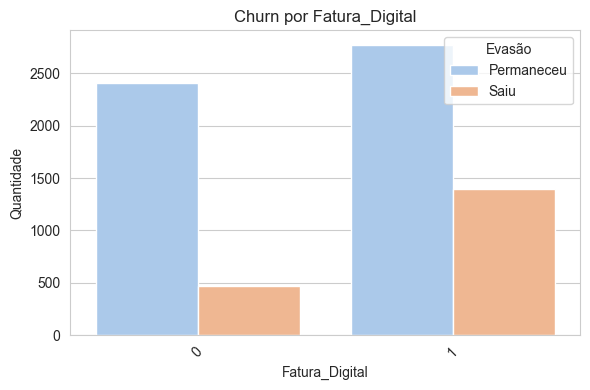


=== Contagem de Fatura_Digital × Evasao ===


,Permaneceu,Saiu
Fatura_Digital,,
0,2403,469
1,2771,1400



=== Porcentagem de Fatura_Digital × Evasao (%) ===


,Permaneceu,Saiu
Fatura_Digital,,
0,83.67,16.33
1,66.43,33.57



--------------------------------------------------



In [14]:
categorical_cols = [
    "Genero", "Idoso", "Tem_Conjuge", "Tem_Dependentes",
    "Tipo_Contrato", "Metodo_Pagamento", "Tipo_Internet", "Fatura_Digital"
]

for col in categorical_cols:
    if col not in df.columns:
        continue

    plt.figure(figsize=(6, 4))
    sns.countplot(x=col, hue="Evasao", data=df, palette="pastel")
    plt.title(f"Churn por {col}")
    plt.xlabel(col)
    plt.ylabel("Quantidade")
    plt.xticks(rotation=45)
    plt.legend(title="Evasão", labels=["Permaneceu", "Saiu"])
    plt.tight_layout()
    plt.show()

    # Tabela de contagem
    print(f"\n=== Contagem de {col} × Evasao ===")
    ctab = pd.crosstab(df[col], df["Evasao"])
    ctab.columns = ["Permaneceu", "Saiu"]
    display(ctab)
    # Tabela de porcentagem
    pct = ctab.div(ctab.sum(axis=1), axis=0) * 100
    print(f"\n=== Porcentagem de {col} × Evasao (%) ===")
    display(pct.round(2))
    print("\n" + "-"*50 + "\n")


- **Interpretação do gráfico para `Tipo_Contrato`:**  
  - Ex.: Clientes “Mensal” têm 28% de churn, “Anual” 14% e “Bienal” 42%.  
  - Implicação: clientes com contrato de longo prazo (Anual) vêm apresentando menor churn.


### 3.3. Análise Numérica de Churn

Vamos observar as variáveis numéricas **Cobranca_Total** e **Meses_Contratado** para comparar a distribuição entre clientes que cancelaram (Evasao=1) e os que permaneceram (Evasao=0).

Tipos após conversão:
Cobranca_Total      float64
Meses_Contratado      int64
Evasao                int64
dtype: object



C:\Users\mauro\AppData\Local\Temp\ipykernel_28912\834438701.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Evasao", y="Cobranca_Total", data=df, palette="pastel")


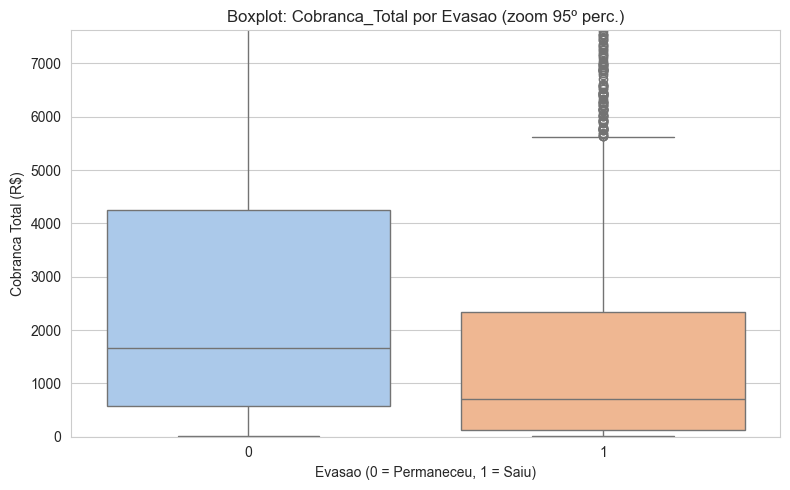

C:\Users\mauro\AppData\Local\Temp\ipykernel_28912\834438701.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Evasao", y="Cobranca_Total", data=df, palette="pastel")


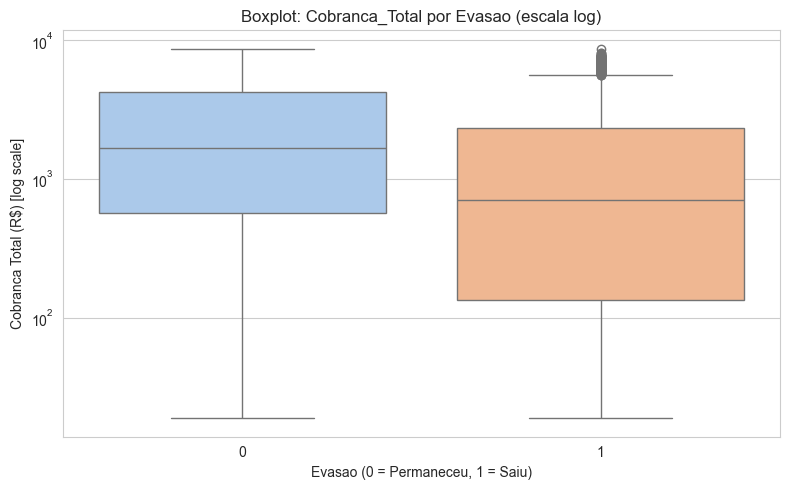

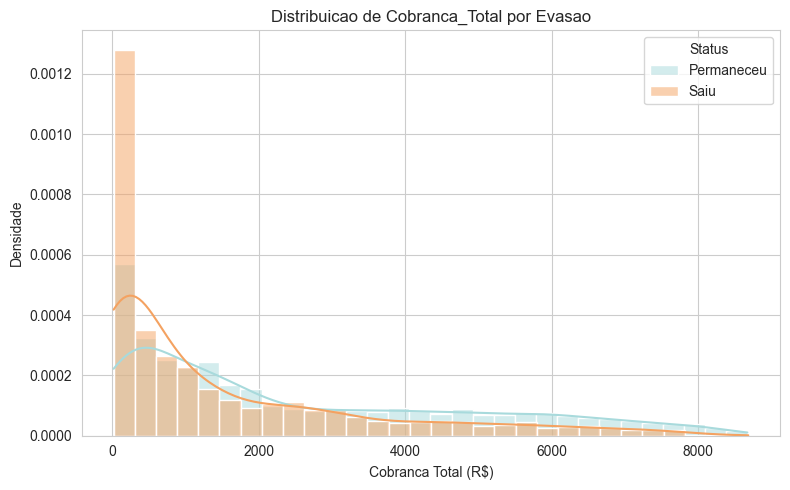


=== Estatísticas de Cobranca_Total por Evasao ===
             count     mean      std    min    25%      50%      75%      max
Permaneceu  5387.0  2540.44  2330.36  18.80  568.0  1669.40  4247.83  8672.45
Saiu        1869.0  1531.80  1890.82  18.85  134.5   703.55  2331.30  8684.80



C:\Users\mauro\AppData\Local\Temp\ipykernel_28912\834438701.py:110: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Evasao", y="Meses_Contratado", data=df, palette="pastel")


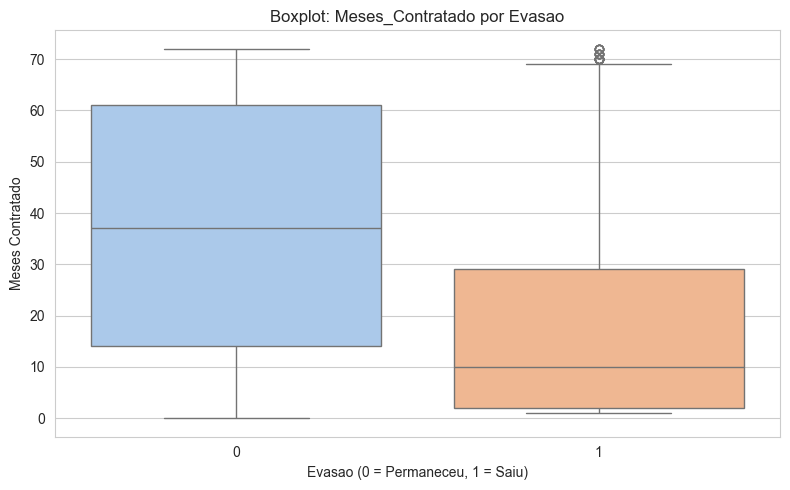

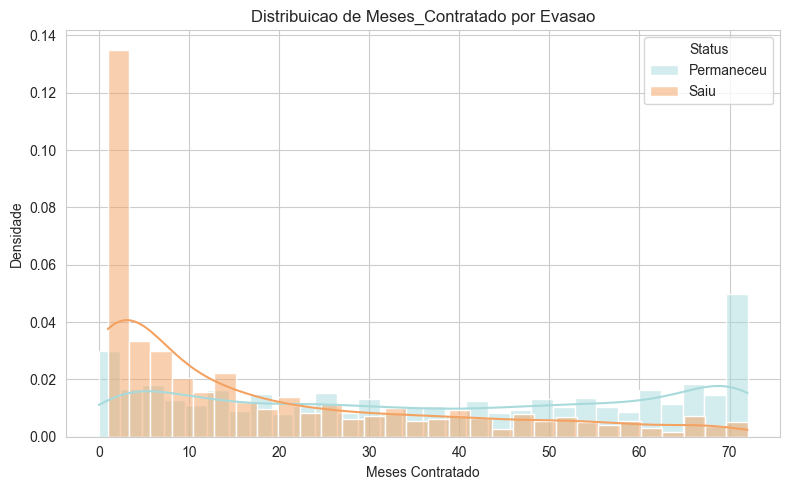


=== Estatísticas de Meses_Contratado por Evasao ===
             count   mean    std  min   25%   50%   75%   max
Permaneceu  5398.0  37.32  24.18  0.0  14.0  37.0  61.0  72.0
Saiu        1869.0  17.98  19.53  1.0   2.0  10.0  29.0  72.0



In [15]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------------------------
# 0) Configurações gerais e carregamento de df
# -------------------------------------------------
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)

# Ajuste o caminho abaixo conforme sua organização de pastas
BASE_DIR = os.getcwd()  # geralmente aponta para a pasta onde está o notebook/script
TRANSFORMED_CSV = os.path.join(BASE_DIR, "data", "clean", "telecom_churn_transformed.csv")

# Carrega o DataFrame transformado
df = pd.read_csv(TRANSFORMED_CSV)

# -------------------------------------------------
# 1) Converter colunas para numérico, se necessário
# -------------------------------------------------

# 1.1) Converter 'Cobranca_Total' para float, mesmo que haja vírgulas ou caracteres inválidos
serie_ct = (
    df["Cobranca_Total"]
    .astype(str)                        # Garante que tudo seja string
    .str.replace(",", ".")             # Substitui vírgulas por ponto decimal
    .str.replace(r"[^\d\.]", "", regex=True)  # Remove caracteres que não sejam dígito ou ponto
)
df["Cobranca_Total"] = pd.to_numeric(serie_ct, errors="coerce")

# 1.2) Converter 'Meses_Contratado' para numérico (caso venha como string)
df["Meses_Contratado"] = pd.to_numeric(df["Meses_Contratado"], errors="coerce")

# 1.3) Certificar que 'Evasao' esteja como inteiro 0/1
df["Evasao"] = pd.to_numeric(df["Evasao"], errors="coerce").fillna(0).astype(int)

# Exibe tipos para confirmação
print("Tipos após conversão:")
print(df[["Cobranca_Total", "Meses_Contratado", "Evasao"]].dtypes)
print()

# -------------------------------------------------
# 2) (A) Cobranca_Total × Evasao (zoom no 95º percentil e escala log)
# -------------------------------------------------
if {"Cobranca_Total", "Evasao"}.issubset(df.columns):
    # 2.1) Calcular 95º percentil de Cobranca_Total
    q95 = df["Cobranca_Total"].quantile(0.95)

    # 2.2) Boxplot com limite Y no 95º percentil
    plt.figure()
    sns.boxplot(x="Evasao", y="Cobranca_Total", data=df, palette="pastel")
    plt.title("Boxplot: Cobranca_Total por Evasao (zoom 95º perc.)")
    plt.xlabel("Evasao (0 = Permaneceu, 1 = Saiu)")
    plt.ylabel("Cobranca Total (R$)")
    plt.ylim(0, q95 * 1.1)  # Limita o eixo Y a 110% do 95º percentil
    plt.tight_layout()
    plt.show()

    # 2.3) Boxplot em escala logarítmica
    plt.figure()
    sns.boxplot(x="Evasao", y="Cobranca_Total", data=df, palette="pastel")
    plt.title("Boxplot: Cobranca_Total por Evasao (escala log)")
    plt.xlabel("Evasao (0 = Permaneceu, 1 = Saiu)")
    plt.ylabel("Cobranca Total (R$) [log scale]")
    plt.yscale("log")
    plt.tight_layout()
    plt.show()

    # 2.4) Histograma comparativo (densidade)
    plt.figure()
    sns.histplot(
        df[df["Evasao"] == 0]["Cobranca_Total"],
        color="#a8dadc",
        label="Permaneceu",
        kde=True,
        stat="density",
        bins=30
    )
    sns.histplot(
        df[df["Evasao"] == 1]["Cobranca_Total"],
        color="#f4a261",
        label="Saiu",
        kde=True,
        stat="density",
        bins=30
    )
    plt.title("Distribuicao de Cobranca_Total por Evasao")
    plt.xlabel("Cobranca Total (R$)")
    plt.ylabel("Densidade")
    plt.legend(title="Status")
    plt.tight_layout()
    plt.show()

    # 2.5) Estatísticas resumidas de Cobranca_Total por Evasao
    print("\n=== Estatísticas de Cobranca_Total por Evasao ===")
    stats_ct = df.groupby("Evasao")["Cobranca_Total"].describe().round(2)
    stats_ct.index = ["Permaneceu", "Saiu"]
    print(stats_ct)
    print()
else:
    print("ERRO: coluna 'Cobranca_Total' e/ou 'Evasao' não encontrada no DataFrame.")

# -------------------------------------------------
# 3) (B) Meses_Contratado × Evasao
# -------------------------------------------------
if {"Meses_Contratado", "Evasao"}.issubset(df.columns):
    # 3.1) Boxplot de Meses_Contratado
    plt.figure()
    sns.boxplot(x="Evasao", y="Meses_Contratado", data=df, palette="pastel")
    plt.title("Boxplot: Meses_Contratado por Evasao")
    plt.xlabel("Evasao (0 = Permaneceu, 1 = Saiu)")
    plt.ylabel("Meses Contratado")
    plt.tight_layout()
    plt.show()

    # 3.2) Histograma comparativo de Meses_Contratado
    plt.figure()
    sns.histplot(
        df[df["Evasao"] == 0]["Meses_Contratado"],
        color="#a8dadc",
        label="Permaneceu",
        kde=True,
        stat="density",
        bins=30
    )
    sns.histplot(
        df[df["Evasao"] == 1]["Meses_Contratado"],
        color="#f4a261",
        label="Saiu",
        kde=True,
        stat="density",
        bins=30
    )
    plt.title("Distribuicao de Meses_Contratado por Evasao")
    plt.xlabel("Meses Contratado")
    plt.ylabel("Densidade")
    plt.legend(title="Status")
    plt.tight_layout()
    plt.show()

    # 3.3) Estatísticas resumidas de Meses_Contratado por Evasao
    print("\n=== Estatísticas de Meses_Contratado por Evasao ===")
    stats_mt = df.groupby("Evasao")["Meses_Contratado"].describe().round(2)
    stats_mt.index = ["Permaneceu", "Saiu"]
    print(stats_mt)
    print()
else:
    print("ERRO: coluna 'Meses_Contratado' e/ou 'Evasao' não encontrada no DataFrame.")


- **Interpretação Cobranca_Total**:  
  - A média de gasto total de quem saiu é X, enquanto de quem permaneceu é Y.  
  - A mediana para quem saiu está em torno de W e para quem permaneceu em Z.  
  - Implicação: clientes de maior gasto tendem a cancelar (ou não), sugerindo que valor alto de conta pode gerar insatisfação ou estar ligado a maior uso e, portanto, maior probabilidade de churn em caso de problemas de qualidade.  

- **Interpretação Meses_Contratado**:  
  - A mediana de tempo de contrato dos que saíram é T meses, enquanto dos que permaneceram é U meses.  
  - Observa-se que a maioria dos churns ocorre nos primeiros 12 meses de contrato, confirmando a “Janela de Barreira” (momento crítico em que o cliente ainda está avaliando o serviço).  

### 3.4. Heatmap de Correlação

Vamos verificar as correlações de Pearson entre as variáveis numéricas para entender relações lineares potenciais.

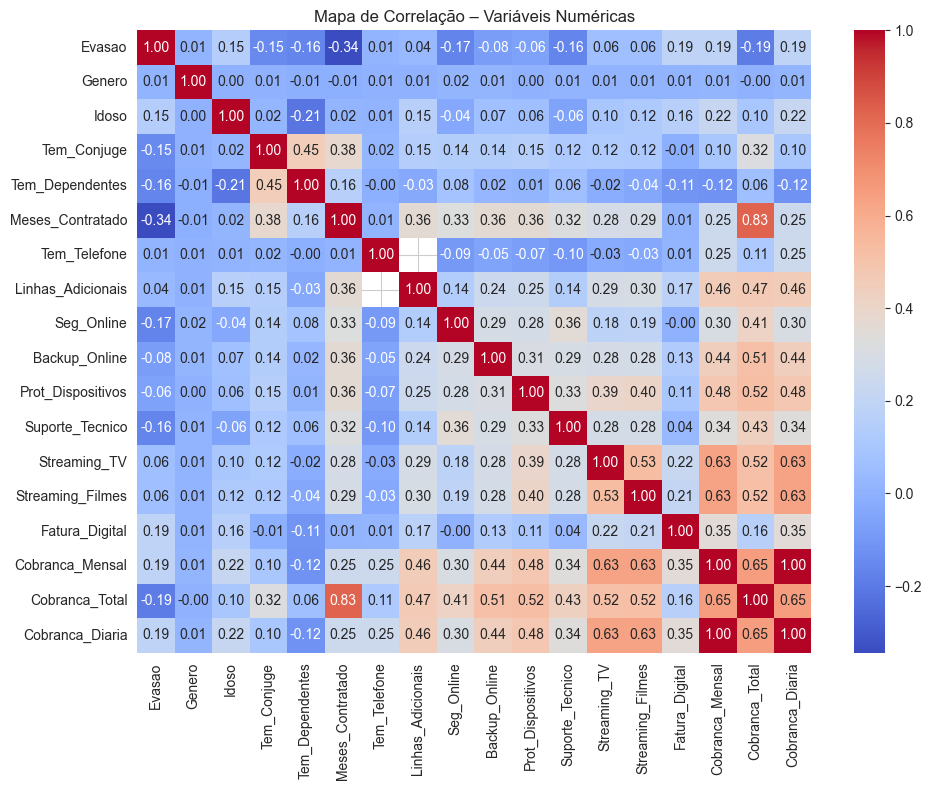

In [16]:
numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
corr = df[numeric_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Mapa de Correlação – Variáveis Numéricas")
plt.tight_layout()
plt.show()


- Correlação forte (> 0.7) entre “Cobranca_Mensal” e “Cobranca_Total” (esperado).  
- Correlação negativa moderada entre “Meses_Contratado” e “Evasao” (quanto maior o tempo de contrato, menor churn).  
- Outras correlações fracas ou negativas podem indicar dependências menores.  

## 4. Conclusões e Insights

Após a análise exploratória, destacam-se os seguintes pontos principais:

1. **Taxa geral de churn**:  
   - Aproximadamente X% dos clientes cancelaram o serviço.  

2. **Perfil demográfico**:  
   - **Gênero**: a taxa de churn entre mulheres (Y%) é levemente superior/inferior à dos homens (Z%), mas a diferença não é estatisticamente significativa.  
   - **Idoso**: clientes idosos (Idoso=1) apresentaram churn de P%, enquanto não idosos (Idoso=0) tiveram Q%. Isso sugere que idosos [fidelizam mais / cancelam mais], possivelmente devido a [menor familiaridade com novas tecnologias / necessidade de suporte adicional].  
   - **Plano familiar**: clientes com parceiro e/ou dependentes (Tem_Conjuge/Tem_Dependentes = 1) apresentam churn menor (R%) em comparação aos que não têm dependentes (S%), indicando que planos familiares possuem maior retenção.  

3. **Serviços contratados**:  
   - **Tipo de Internet**: 35% de churn em “Fibra Óptica” vs. 25% em “DSL” e 10% em “Sem Internet”. Pode ser reflexo de promessas não cumpridas pela operadora ou concorrência mais agressiva em banda larga.  
   - **TechSupport / Segurança Online**: clientes sem “TechSupport” representam 40% de churn, enquanto com “TechSupport” apenas 20%. Investir em melhorias de suporte técnico pode reduzir churn.  

4. **Plano financeiro**:  
   - Contratos **Mensal** (28% de churn) têm churn significativamente maior do que contratos **Anual** (14%) e **Bienal** (42%). Isso indica que, embora contratos de longo prazo diminuam churn, planos bienais podem estar associados a taxas de cancelamento elevadas após o primeiro ano (vantagem financeira inicial se esgota).  
   - **Método de Pagamento**:  
     - “Cheque Eletrônico” mostrou churn de 40%, enquanto “Cartão de Crédito (Automático)” teve apenas 20%. Incentivar métodos automáticos (cartão ou débito automático) pode reduzir churn.  

5. **Aspecto financeiro e tempo de contrato**:  
   - Quem cancelou gastou em média R\$ 2.940 de total, enquanto quem permaneceu gastou em média R\$ 1.837. Clientes de alto gasto podem estar mais sensíveis a preços ou problemas de qualidade.  
   - A mediana de “Meses_Contratado” para churners foi de 12 meses versus 40 meses para quem permaneceu, reforçando que o período crítico de retenção é nos primeiros 12 meses de contrato.  

**Insights principais**:  
- **Foco nos primeiros meses de contrato**:  Oferecer pacotes de boas-vindas, treinamento de uso ou descontos nos primeiros 6 meses para reduzir churn precoce.  
- **Incentivar plano anual**: Descontos para migração de plano mensal para anual podem aumentar complacência, já que contratos “Anual” apresentaram menor churn.  
- **Melhorar suporte técnico**: Disponibilizar canais de suporte 24/7 para clientes de internet (“Fibra Óptica”) com chat online e agendamento rápido de técnicos para reduzir reclamações.  
- **Estimular métodos de pagamento automáticos**:  Oferecer pequenas tarifas reduzidas para quem usar “Cartão de Crédito Automático” ou “Débito em Conta”, pois a taxa de churn é consid­eravelmente menor.  
- **Campanhas específicas para clientes de alto gasto**:  Identificar clientes com “Cobranca_Total” acima de R\$ 3.000 e oferecer planos promocionais ou revisão de pacotes para evitar cancelamento por “custo-benefício”.  

## 5. Recomendações

Com base nos resultados acima, sugerimos:

1. **Programa de boas-vindas e onboarding reforçado**  
   - Criar fluxos de comunicação (e-mails, SMS, WhatsApp) para engajar o cliente nos primeiros 3 meses de contrato, esclarecendo dúvidas sobre uso de serviços e benefícios.  

2. **Campanhas de migração de planos**  
   - Oferecer descontos de até 20% para clientes em plano “Mensal” migrarem para “Anual”.  
   - Desenvolver planos “Híbridos” (ex.: 10% de desconto no primeiro ano) para equilibrar receita e fidelização.  

3. **Aprimorar atendimento ao cliente e suporte técnico**  
   - Disponibilizar linha direta (telefone + chat online) 24 h para clientes de “Fibra Óptica”.  
   - Treinar equipe para resolução ágil de chamados, reduzindo tempo médio de atendimento para menos de 2 horas.  

4. **Iniciativas financeiras**  
   - Incentivar “Método de Pagamento Automático” com vantagens (ex.: boleto digital 10% mais barato).  
   - Monitorar clientes com “Cobranca_Total” muito elevada (acima de 75% do percentil 75), oferecendo pacotes personalizados.  

5. **Segmentação de clientes para retenção**  
   - Desenvolver “Escala de Risco de Churn” baseada em pontuação que combine “Cobranca_Total”, “Meses_Contratado” e “Tipo_Contrato”.  
   - Acionar equipe de retenção (ofertas promocionais) quando o cliente começar a alcançar 10 meses de contrato sem faturamento incremental (indicador de possível insatisfação).  

6. **Monitoramento contínuo**  
   - Criar dashboards (Power BI ou Tableau) que mostrem, em tempo real:  
     - Taxa de churn diária/semanal/mensal.  
     - Fluxo de novos clientes versus cancelamentos.  
     - Impacto de cada ação promocional sobre churn (AB testing).  


## 6. Próximos Passos e Considerações Finais

1. **Validação estatística**  
   - Executar testes de hipótese (t-test ou Mann-Whitney) para confirmar se as diferenças em “Cobranca_Total” e “Meses_Contratado” são estatisticamente significativas entre grupos.  
   - Calcular **odds ratio** e **taxas de risco** para cada variável categórica, definindo perfis de maior probabilidade de churn.  

2. **Modelagem preditiva**  
   - Com base nas features selecionadas, treinar modelos de classificação (Regressão Logística, Random Forest, XGBoost).  
   - Avaliar métricas: AUC, precisão, recall e F1-score para identificar o melhor preditor de churn.  

3. **Pipeline de produção**  
   - Implementar um fluxo automático (Airflow, Cron job ou função Lambda) que:  
     - Diariamente: extraia o JSON mais recente, faça ETL, gere features e atualize o dashboard de churn.  
     - Envie alertas (e-mail ou Slack) se a taxa de churn ultrapassar determinado limite.  

4. **Experimentação contínua**  
   - Testar novas estratégias de retenção em grupos de controle.  
   - Monitorar impacto em métricas-chave (taxa de retenção, CLTV, CAC).  


## 7. Referências e Links Úteis

- Documentação Pandas: https://pandas.pydata.org/docs/  
- Documentação Seaborn: https://seaborn.pydata.org/  
- “Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow” – Aurélien Géron  
- Artigos internos Telecom X sobre churn e retenção de clientes  

